### Load libraries.

In [1]:
import numpy as np
import geopandas as geopd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Load San Luis Potosi metropolitan area shape file. Source: Marco Geoestadístico INEGI (2023).
#### URL: https://www.inegi.org.mx/temas/mg/ 

##### Note:   Marginalization data are available for all Mexican states at AGEB level. Here we show an example  concerning San Luis Potosí Metropolitan Area data.

In [2]:
# INEGI data
gdf = geopd.read_file("../dataset/SLPMA/geometry/2023_1_24_A/2023_1_24_A.shp")

### Display data frame entries

- CVE_ENT: State code provided by INEGI.
- CVE_MUN: Municipality code provided by INEGI.
- CVE_LOC: Location code provided by INEGI.
- CVE_AGEB: Geographic area provided by INEGI.
- AMBITO: Urban or Rural area.
- geometry: Municipality boundary provided by INEGI (polygons).

In [3]:
display(gdf)

CVEGEO CVE_ENT CVE_MUN CVE_LOC CVE_AGEB  AMBITO  \
0     2400100010198      24     001    0001     0198  Urbana   
1     2400100010200      24     001    0001     0200  Urbana   
2     2400100010107      24     001    0001     0107  Urbana   
3     2400100010111      24     001    0001     0111  Urbana   
4     2400100010145      24     001    0001     0145  Urbana   
...             ...     ...     ...     ...      ...     ...   
1577  2405800010237      24     058    0001     0237  Urbana   
1578  2405800010218      24     058    0001     0218  Urbana   
1579  2405800010148      24     058    0001     0148  Urbana   
1580  2405800010133      24     058    0001     0133  Urbana   
1581  2405800010129      24     058    0001     0129  Urbana   

                                               geometry  
0     POLYGON ((-101.15796 22.39861, -101.15829 22.3...  
1     POLYGON ((-101.15675 22.39860, -101.15675 22.3...  
2     POLYGON ((-101.16092 22.40463, -101.16092 22.4...  
3     POLYGON ((-101.16742 22.40622, -101.16756 22.4...  
4     POLYGON ((-101.16331 22.40754, -101.16353 22.4...  
...                                                 ...  
1577  POLYGON ((-99.30914 22.53072, -99.30760 22.528...  
1578  POLYGON ((-99.33210 22.54050, -99.33291 22.540...  
1579  POLYGON ((-99.32573 22.52434, -99.32573 22.524...  
1580  POLYGON ((-99.33050 22.53016, -99.33043 22.530...  
1581  POLYGON ((-99.32858 22.54007, -99.32837 22.539...  

[1582 rows x 7 columns]

### San Luis Potosi metropilitan area consist of two municipalities: San Luis Potosí and Soledad de Graciasno Sánchez (SGS).

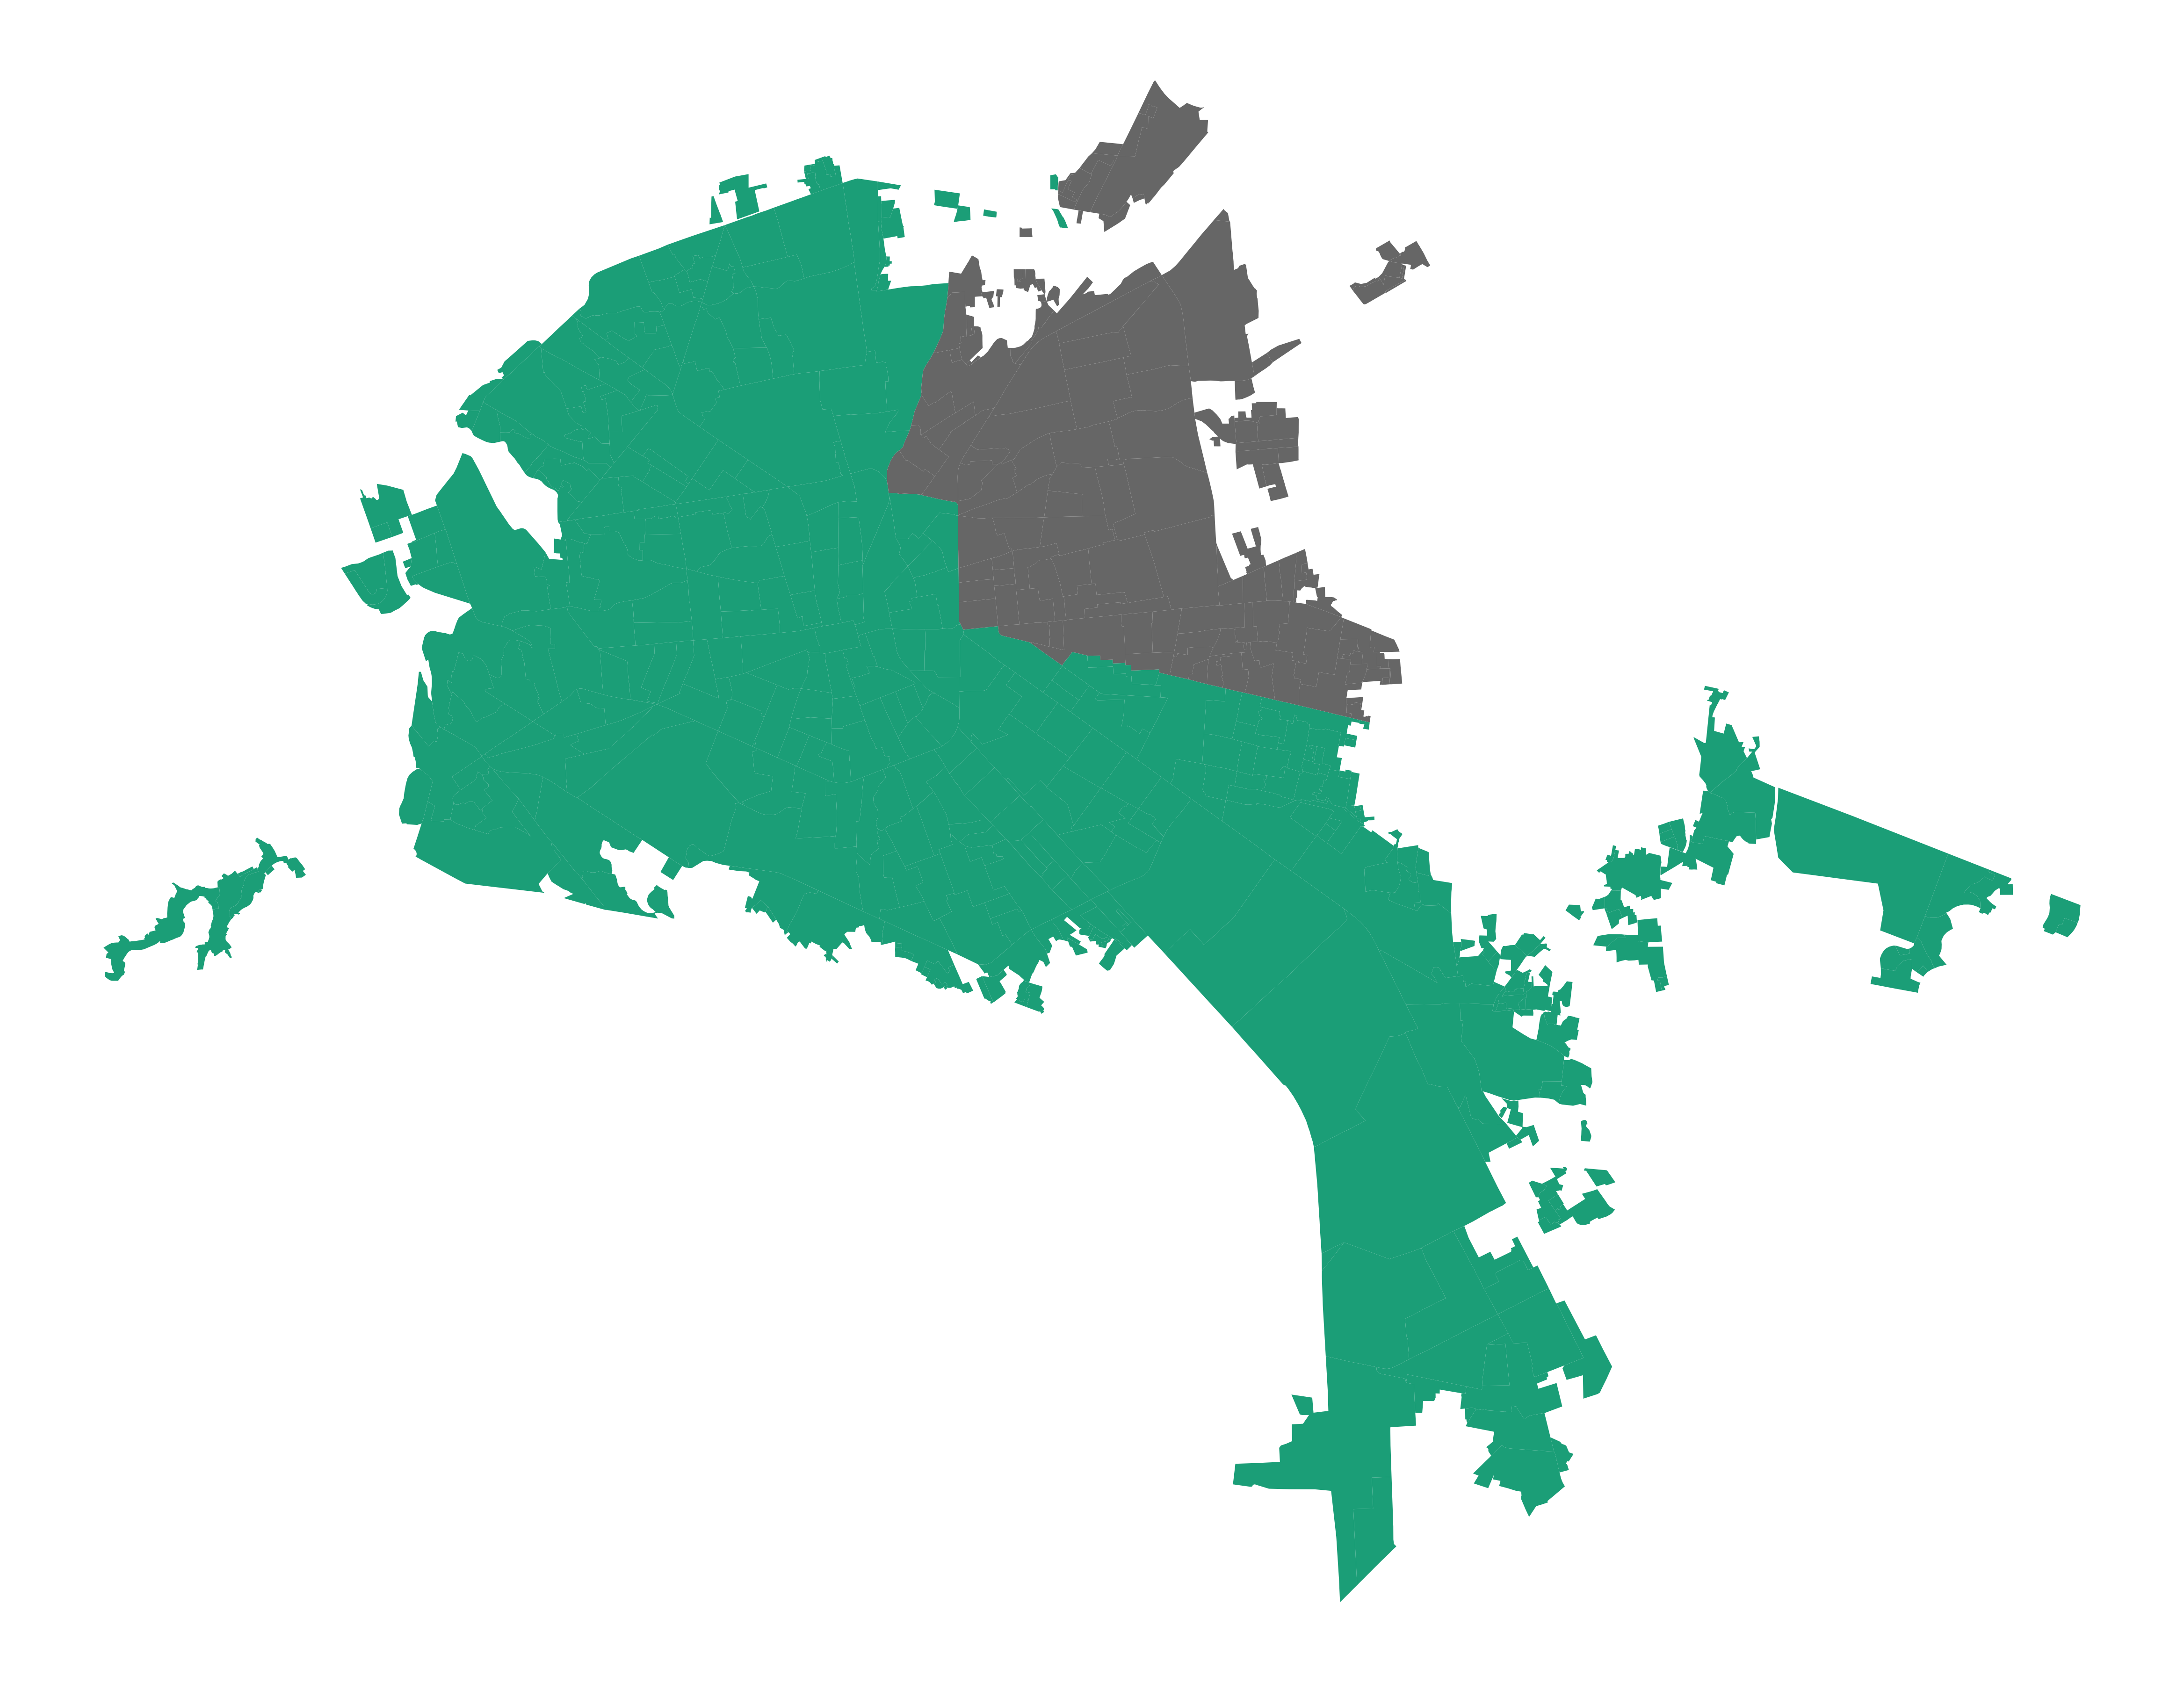

In [4]:
# SLPMA's map labeling each state by a color. 
# AGEBS are identified bya a CVE_ENT code

# SLP
gdf_slp = gdf[gdf["CVE_MUN"] == "028"]

#SGS
gdf_sgs = gdf[ gdf["CVE_MUN"] == "035"]

# Concatenate frames
frames = [gdf_slp, gdf_sgs ]
gdf_zmslp = pd.concat(frames)

# Plot SLP and SGS municipalities
ax = gdf_zmslp.plot(figsize = (60, 60),cmap='Dark2',column="CVE_MUN")
ax.set_axis_off()

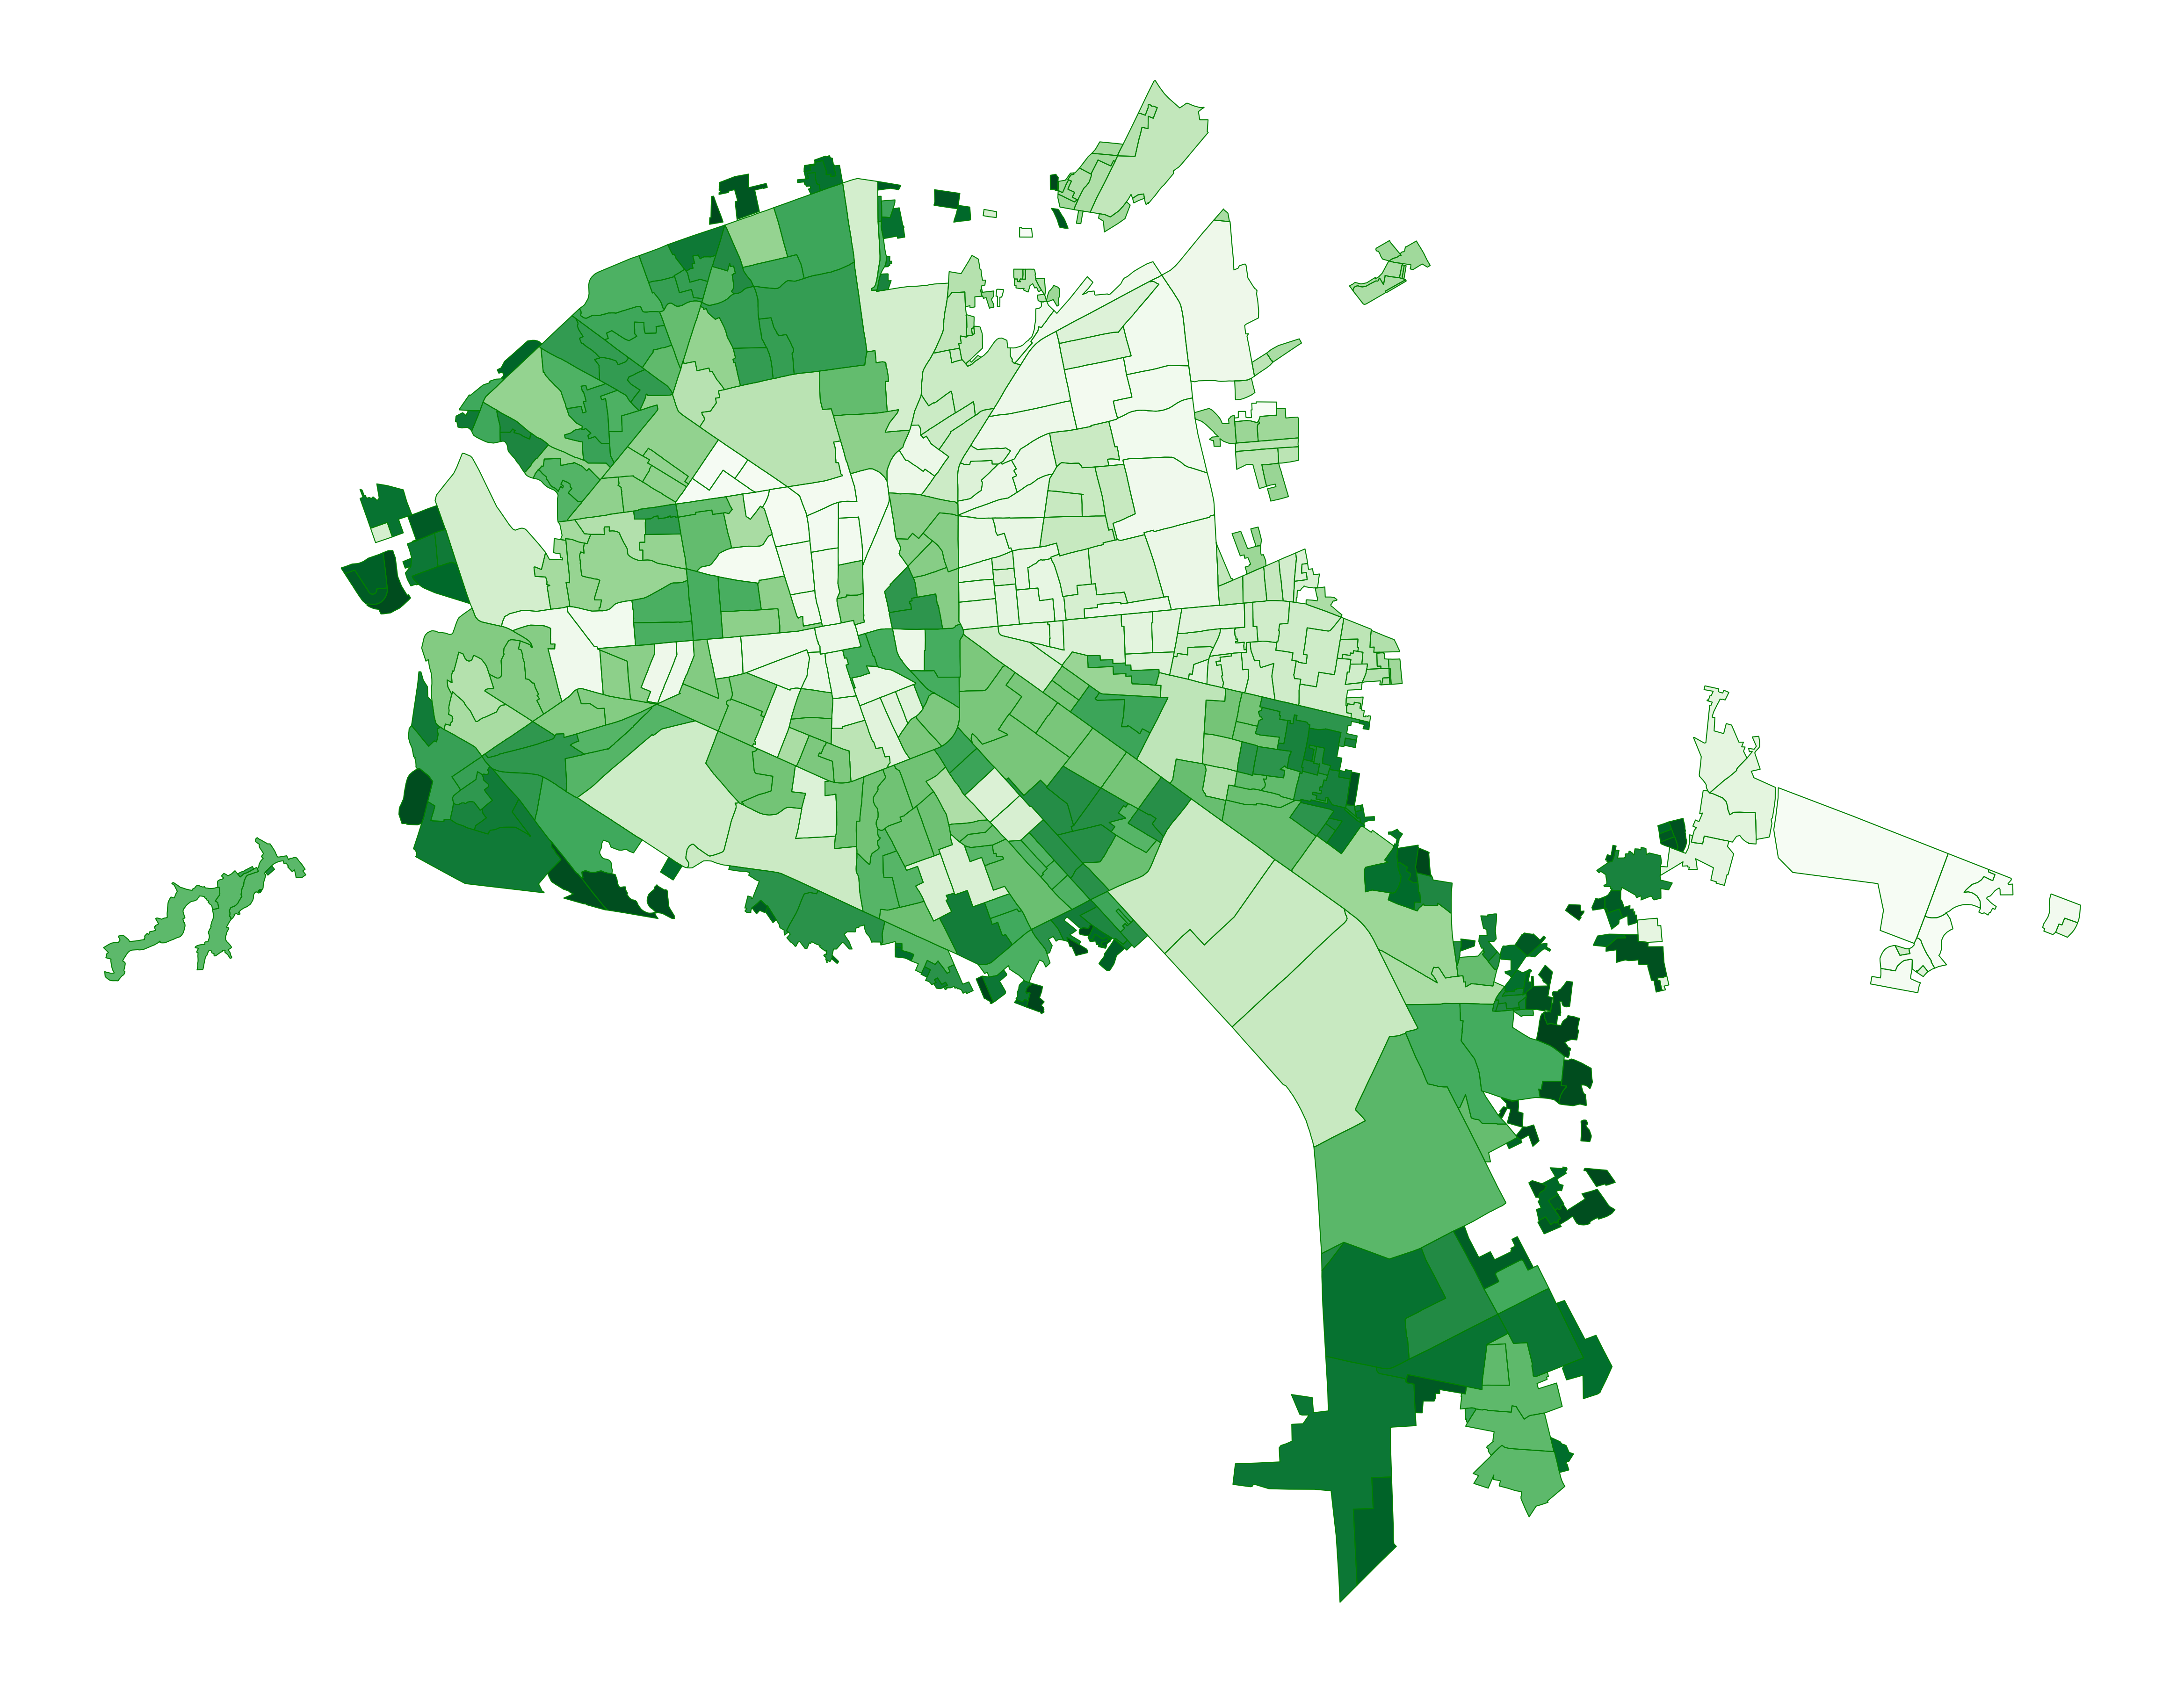

In [5]:
# Plot AGEBS
ax = gdf_zmslp.plot(figsize = (60, 60), column="CVE_AGEB", cmap = "Greens")
ax.set_axis_off()

# Include AGEB outlines.
gdf_zmslp.boundary.plot(ax=ax,figsize = (20, 20), edgecolor='green')
ax.set_axis_off()


### Load marginalization data (AGEB) from CONAPO
### URL: https://www.gob.mx/conapo/documentos/indices-de-marginacion-2020-284372



In [6]:
df = pd.read_csv("../dataset/Mexico/marginalization/IMU_2020.csv")

In [7]:
mapgm = {'Muy bajo': 1, 'Bajo': 2, 'Medio':3, 'Alto': 4, 'Muy alto':5, 'NA': 0 }

df_slp = df[df['ENT'] == 24]

df_slp_slp = df_slp[df_slp['MUN'] == 28].copy()
#display(df_slp_slp)

df_slp = df[df['ENT'] == 24]
df_slp_sgs = df_slp[df_slp['MUN'] == 35]
#display(df_slp_sgs)

frames = [df_slp_slp, df_slp_sgs ]
df_slpma_marginalization_AGEB = pd.concat(frames)
dft = df_slpma_marginalization_AGEB.reset_index()
#dft.info()
#display(dft)

gdf_zmslp = gdf_zmslp.reset_index()
#display(gdf_zmslp)

marginalization_index = []
for i in range(0,len(gdf_zmslp)):
    MUN = int(gdf_zmslp['CVE_MUN'].iloc[i])
    AGEB = str(gdf_zmslp['CVE_AGEB'].iloc[i])
    #print(f"(MUN == {MUN}) and (AGEB ==''{AGEB})''")
    result = dft.query(f"(MUN == {MUN}) and (AGEB =='{AGEB}')")
    if len(result) > 0:
        marginalization_index.append(result['GM_2020'].iloc[0])
        #print(result['IM_2020'].iloc[0])
    else:  
        #print(MUN,AGEB)
        marginalization_index.append('N/A')
        #marginalization_index.append(0)
        
        
total_population = []
for i in range(0,len(gdf_zmslp)):
    MUN = int(gdf_zmslp['CVE_MUN'].iloc[i])
    AGEB = str(gdf_zmslp['CVE_AGEB'].iloc[i])
    #print(f"(MUN == {MUN}) and (AGEB ==''{AGEB})''")
    result = dft.query(f"(MUN == {MUN}) and (AGEB =='{AGEB}')")
    if len(result) > 0:
        total_population.append(result['POB_TOTAL'].iloc[0])
    else:  
        total_population.append(0)
maxpop = max(total_population) 

# Normalize population size
count = 0
for t in total_population:
    count = count + t
    
tp = []    
for t in total_population: 
    tp.append((t/count*100))
        
total_population = tp.copy()        
        
print('Total population',count)   

# Create population ranks


ranks = 5
np.linspace(1,maxpop,5)

total_population_r = []
for i in range(0,len(gdf_zmslp)):
    MUN = int(gdf_zmslp['CVE_MUN'].iloc[i])
    AGEB = str(gdf_zmslp['CVE_AGEB'].iloc[i])
    #print(f"(MUN == {MUN}) and (AGEB ==''{AGEB})''")
    result = dft.query(f"(MUN == {MUN}) and (AGEB =='{AGEB}')")
    if len(result) > 0:
        pob = result['POB_TOTAL'].iloc[0]
        val = str(int(np.round((maxpop-pob)/maxpop*ranks)))
        total_population_r.append(val)
    else:  
        total_population_r.append(str(0))
        
print(total_population_r)        
        
range_ = np.linspace(1,maxpop,ranks+1)       

pop_range  = []
for r in range_:
    val = str(int(np.round(r)))
    pop_range.append(val)
    print(val)
    
  

Total population 1191785
['2', '5', '5', '0', '5', '0', '5', '1', '4', '5', '3', '3', '4', '4', '3', '5', '4', '3', '3', '4', '3', '4', '4', '0', '5', '5', '4', '4', '0', '4', '3', '5', '0', '0', '0', '4', '0', '4', '0', '5', '5', '4', '4', '4', '4', '3', '5', '4', '4', '4', '4', '5', '4', '5', '4', '4', '4', '4', '5', '4', '4', '4', '4', '4', '4', '4', '3', '2', '3', '0', '4', '4', '0', '5', '0', '3', '4', '3', '4', '3', '4', '3', '3', '4', '4', '4', '4', '3', '4', '3', '5', '5', '5', '4', '4', '4', '4', '4', '5', '4', '4', '3', '3', '4', '3', '4', '0', '3', '3', '3', '3', '4', '3', '4', '4', '3', '3', '1', '3', '4', '3', '4', '3', '4', '4', '3', '3', '4', '4', '4', '4', '4', '4', '3', '4', '4', '4', '4', '4', '4', '5', '4', '3', '4', '4', '0', '3', '0', '3', '4', '3', '4', '4', '3', '4', '3', '5', '4', '3', '4', '2', '4', '4', '4', '4', '4', '0', '5', '4', '4', '4', '4', '3', '4', '4', '4', '5', '3', '4', '2', '5', '3', '0', '3', '3', '0', '0', '4', '5', '5', '5', '4', '5', '5', '0',

In [8]:
    

df_proj = gdf_zmslp.to_crs("+proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
print(df_proj)
df_proj['area_m2'] = df_proj['geometry'].area

     index         CVEGEO CVE_ENT CVE_MUN CVE_LOC CVE_AGEB  AMBITO  \
0      612  2402800013251      24     028    0001     3251  Urbana   
1      613  2402800012997      24     028    0001     2997  Urbana   
2      614  2402800015351      24     028    0001     5351  Urbana   
3      615  2402802395385      24     028    0239     5385  Urbana   
4      616  2402800015366      24     028    0001     5366  Urbana   
..     ...            ...     ...     ...     ...      ...     ...   
522   1183  2403500010092      24     035    0001     0092  Urbana   
523   1184  2403500010444      24     035    0001     0444  Urbana   
524   1185  2403500011692      24     035    0001     1692  Urbana   
525   1186  2403500011245      24     035    0001     1245  Urbana   
526   1187  2403500261211      24     035    0026     1211  Urbana   

                                              geometry  
0    POLYGON ((296585.250 2456941.214, 296572.892 2...  
1    POLYGON ((297038.933 2457540.849, 297043

In [9]:
print(df_proj[['area_m2']])    

          area_m2
0    1.391434e+06
1    8.131923e+04
2    1.036472e+05
3    2.849742e+03
4    3.711229e+04
..            ...
522  2.978260e+04
523  2.690803e+06
524  4.528398e+04
525  7.023745e+04
526  1.768578e+06

[527 rows x 1 columns]


In [10]:
gdf_zmslp.insert(2,'GM', marginalization_index )
gdf_zmslp.insert(2,'POB_TOTAL', total_population )
gdf_zmslp.insert(2,'POB_TOTAL_RANKED', total_population_r )

In [11]:
#print(len(gdf_zmslp['POB_TOTAL_RANKED']))

#for a in gdf_zmslp['POB_TOTAL_RANKED']:
#    print(a)

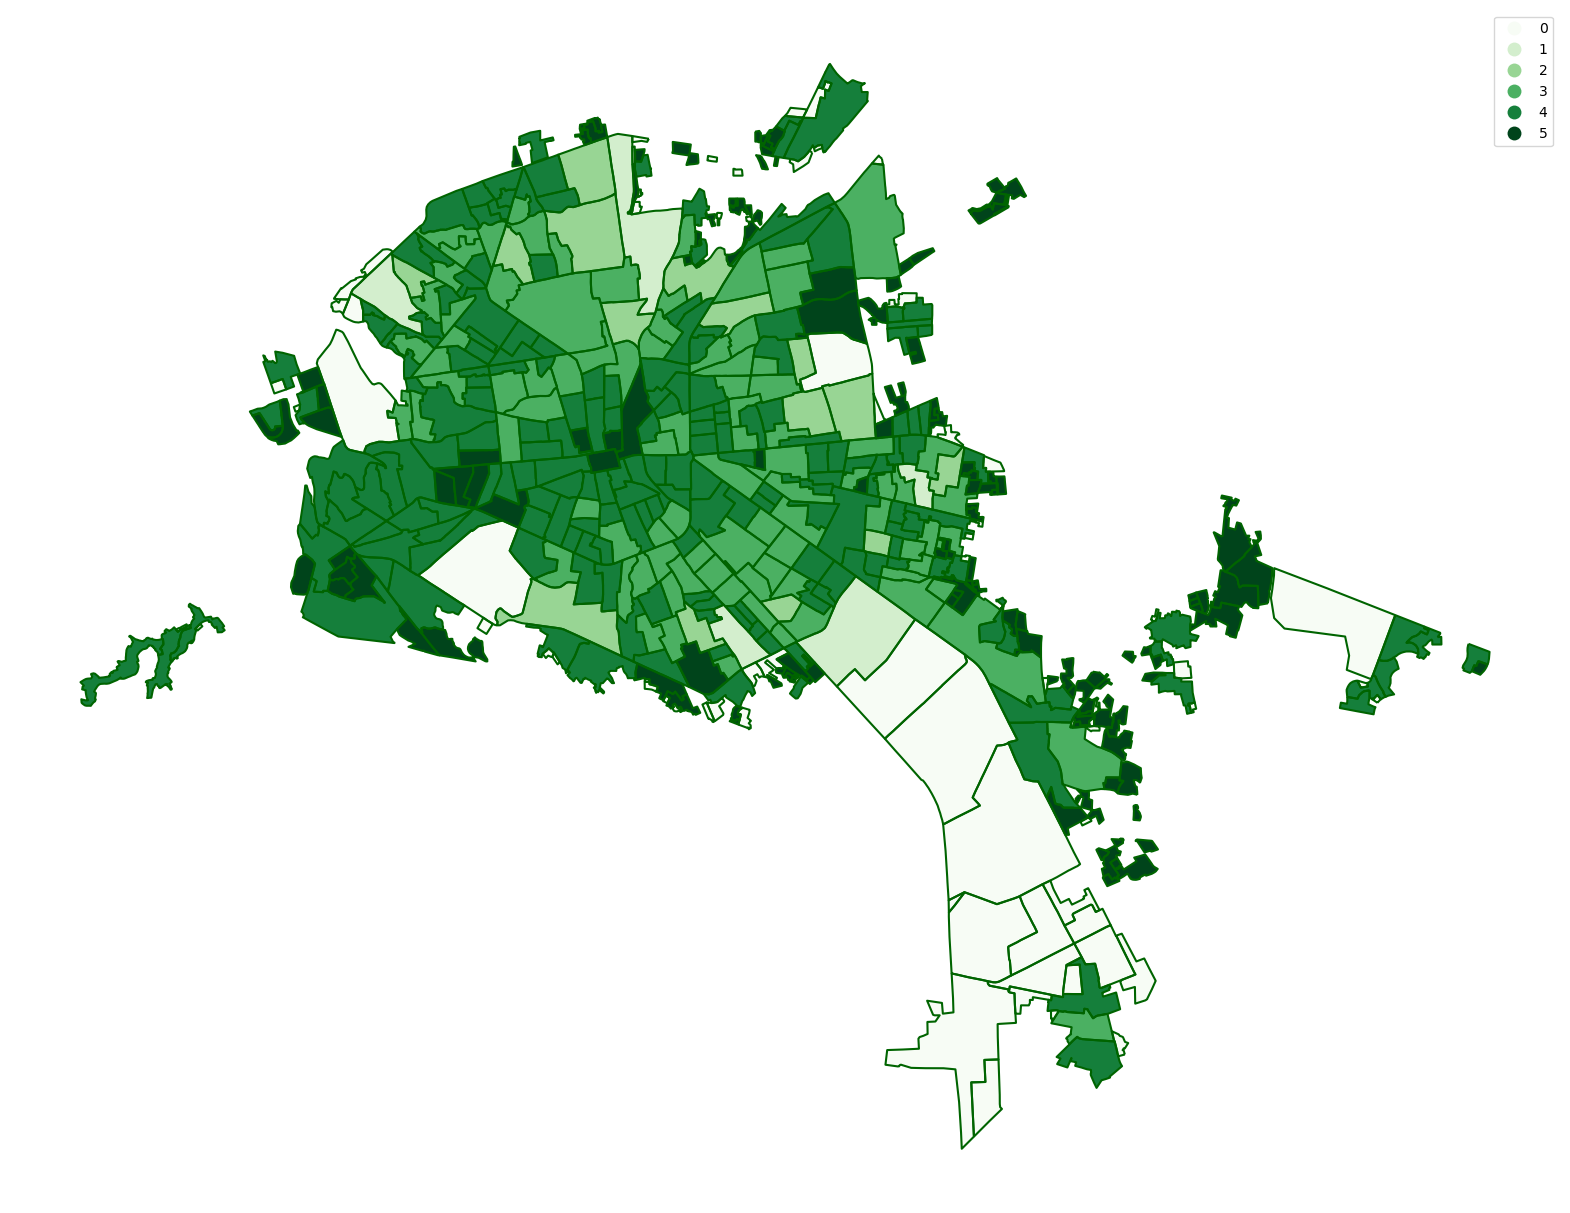

In [12]:
ax =gdf_zmslp.plot(figsize = (20, 20),column='POB_TOTAL_RANKED',cmap=plt.colormaps['Greens'], legend=True)
gdf_zmslp.boundary.plot(ax=ax,figsize = (20, 20), edgecolor='darkgreen')
ax.set_axis_off()

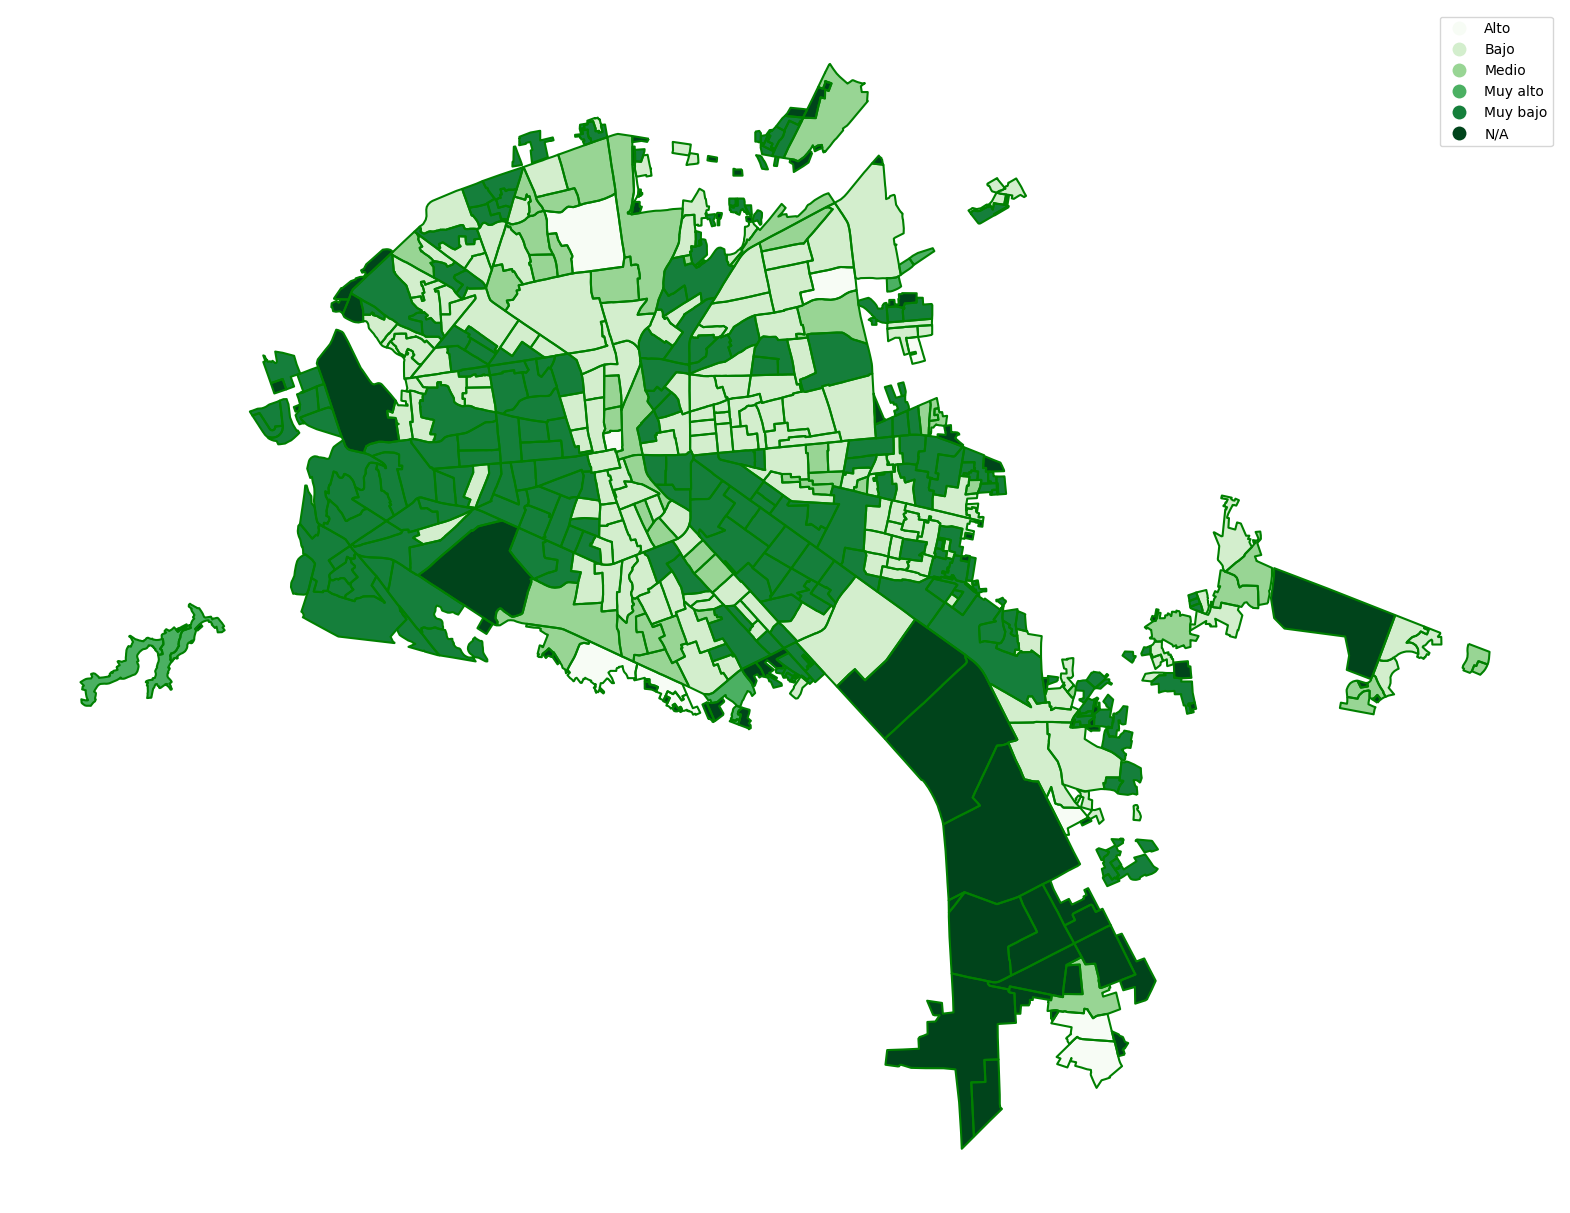

In [13]:
ax =gdf_zmslp.plot(figsize = (20, 20),column='GM',cmap=plt.colormaps['Greens'], legend=True)
gdf_zmslp.boundary.plot(ax=ax,figsize = (20, 20), edgecolor='green')
ax.set_axis_off()

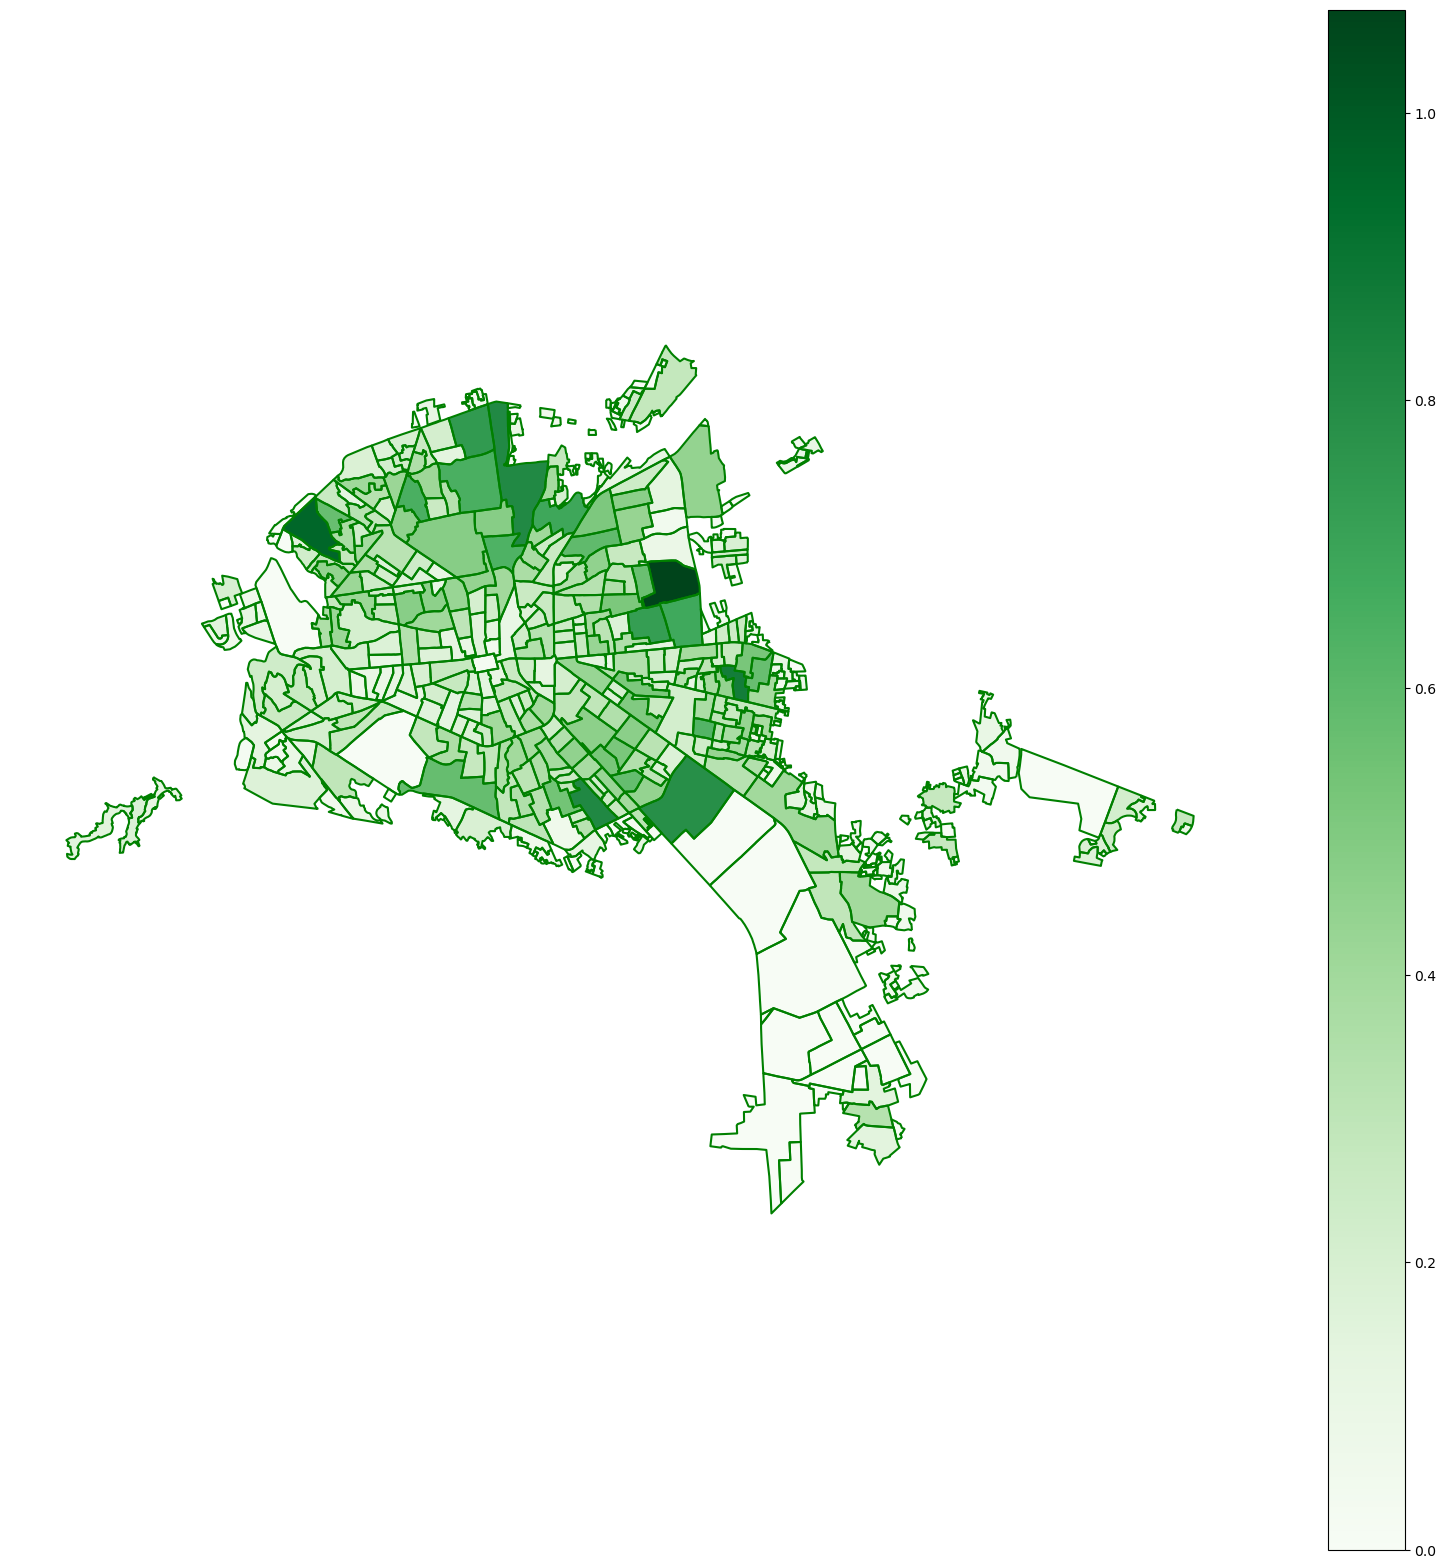

In [14]:
ax =gdf_zmslp.plot(figsize = (20, 20),column='POB_TOTAL',cmap=plt.colormaps['Greens'], legend=True)
gdf_zmslp.boundary.plot(ax=ax,figsize = (20, 20), edgecolor='green')
ax.set_axis_off()

### Display data and marginalization index

In [15]:
df_schools = pd.read_csv("../dataset/SLPMA/preparatorias_slp/preparatoria.csv")
#df_schools = df.sort_values(by=['school'])
#df_schools = df_schools.drop_duplicates(subset=['total escuelas'])

gdf_schools = geopd.GeoDataFrame(
    df_schools, geometry=geopd.points_from_xy(df_schools.Longitud,df_schools.Latitud, crs="epsg:4326",
))

display(gdf_schools)

ID                          Clee  \
0    3664815  24028611161000313000000000U1   
1    3689770  24028611161000512000000000U8   
2    8002474  24035611162000083000000000U3   
3   10165047  24028611162000536000000000U5   
4    3752024  24028611152000024000000000U3   
..       ...                           ...   
78   3738355  24028611162000073000000000U9   
79   3745662  24028611162000184000000000U4   
80   9278986  24035611161000083000000000U5   
81   8546082  24028611161000612000000000U6   
82   3710091  24028611161000431001000000U1   

                        Nombre de la Unidad EconÛmica  \
0   ASOCIACION PREPARATORIA INSTITUTO BENEMERITO D...   
1   BACHILLERATO TECNOLOGICO DEL INSTITUTO BILINGU...   
2                                              CECYTE   
3                              CECYTE 3NUEVO PROGRESO   
4                                    CECYTE PLANTEL 1   
..                                                ...   
78            PREPARATORIA MUNICIPAL PONCIANO ARRIAGA   
79     PREPARATORIA PROFRA. CELIA FERNANDEZ CAPETILLO   
80              PREPARATORIA QUALITY EDUCATION CENTER   
81                          PREPARATORIA SAN LUIS REY   
82                         TBS SERVICIOS PARA MUJERES   

                                         RazÛn social  \
0   ASOCIACION PREPARATORIA INSTITUTO BENEMERITO D...   
1                                                 NaN   
2     SECRETARIA DE EDUCACION DE GOBIERNO DEL ESTADO    
3                         CP EFRAIN NI—O CASTELLANOS    
4   ORGANISMO DESCENTRALIZADO DEL GOBIERNO FEDERAL...   
..                                                ...   
78                 SISTEMA EDUCATIVO ESTATAL REGULAR    
79                               GOBIERNO DEL ESTADO    
80                    QUALITY EDUCATION CENTER SLP AC   
81                       RUBEN MAGDALENO CONTRERAS SC   
82  ESCUELA DE EDUCACI”N MEDIA SUPERIOR DEL SECTOR...   

    CÛdigo de la clase de actividad SCIAN  \
0                                  611161   
1                                  611161   
2                                  611162   
3                                  611162   
4                                  611162   
..                                    ...   
78                                 611162   
79                                 611162   
80                                 611161   
81                                 611161   
82                                 611161   

                      Nombre de clase de la actividad  \
0   Escuelas de educaciÛn media superior del secto...   
1   Escuelas de educaciÛn media superior del secto...   
2   Escuelas de educaciÛn media superior del secto...   
3   Escuelas de educaciÛn media superior del secto...   
4   Escuelas de educaciÛn media superior del secto...   
..                                                ...   
78  Escuelas de educaciÛn media superior del secto...   
79  Escuelas de educaciÛn media superior del secto...   
80  Escuelas de educaciÛn media superior del secto...   
81  Escuelas de educaciÛn media superior del secto...   
82  Escuelas de educaciÛn media superior del secto...   

   Descripcion estrato personal ocupado Tipo de vialidad  \
0                        0 a 5 personas            CALLE   
1                      11 a 30 personas            CALLE   
2                      31 a 50 personas            CALLE   
3                    101 a 250 personas     PROLONGACION   
4                     51 a 100 personas     PROLONGACION   
..                                  ...              ...   
78                     11 a 30 personas            CALLE   
79                     31 a 50 personas            CALLE   
80                       0 a 5 personas          AVENIDA   
81                      6 a 10 personas          AVENIDA   
82                       0 a 5 personas            CALLE   

         Nombre de la vialidad Tipo de entre vialidad 1  ...  \
0                     AVANZADA                    CALLE  ...   
1          A

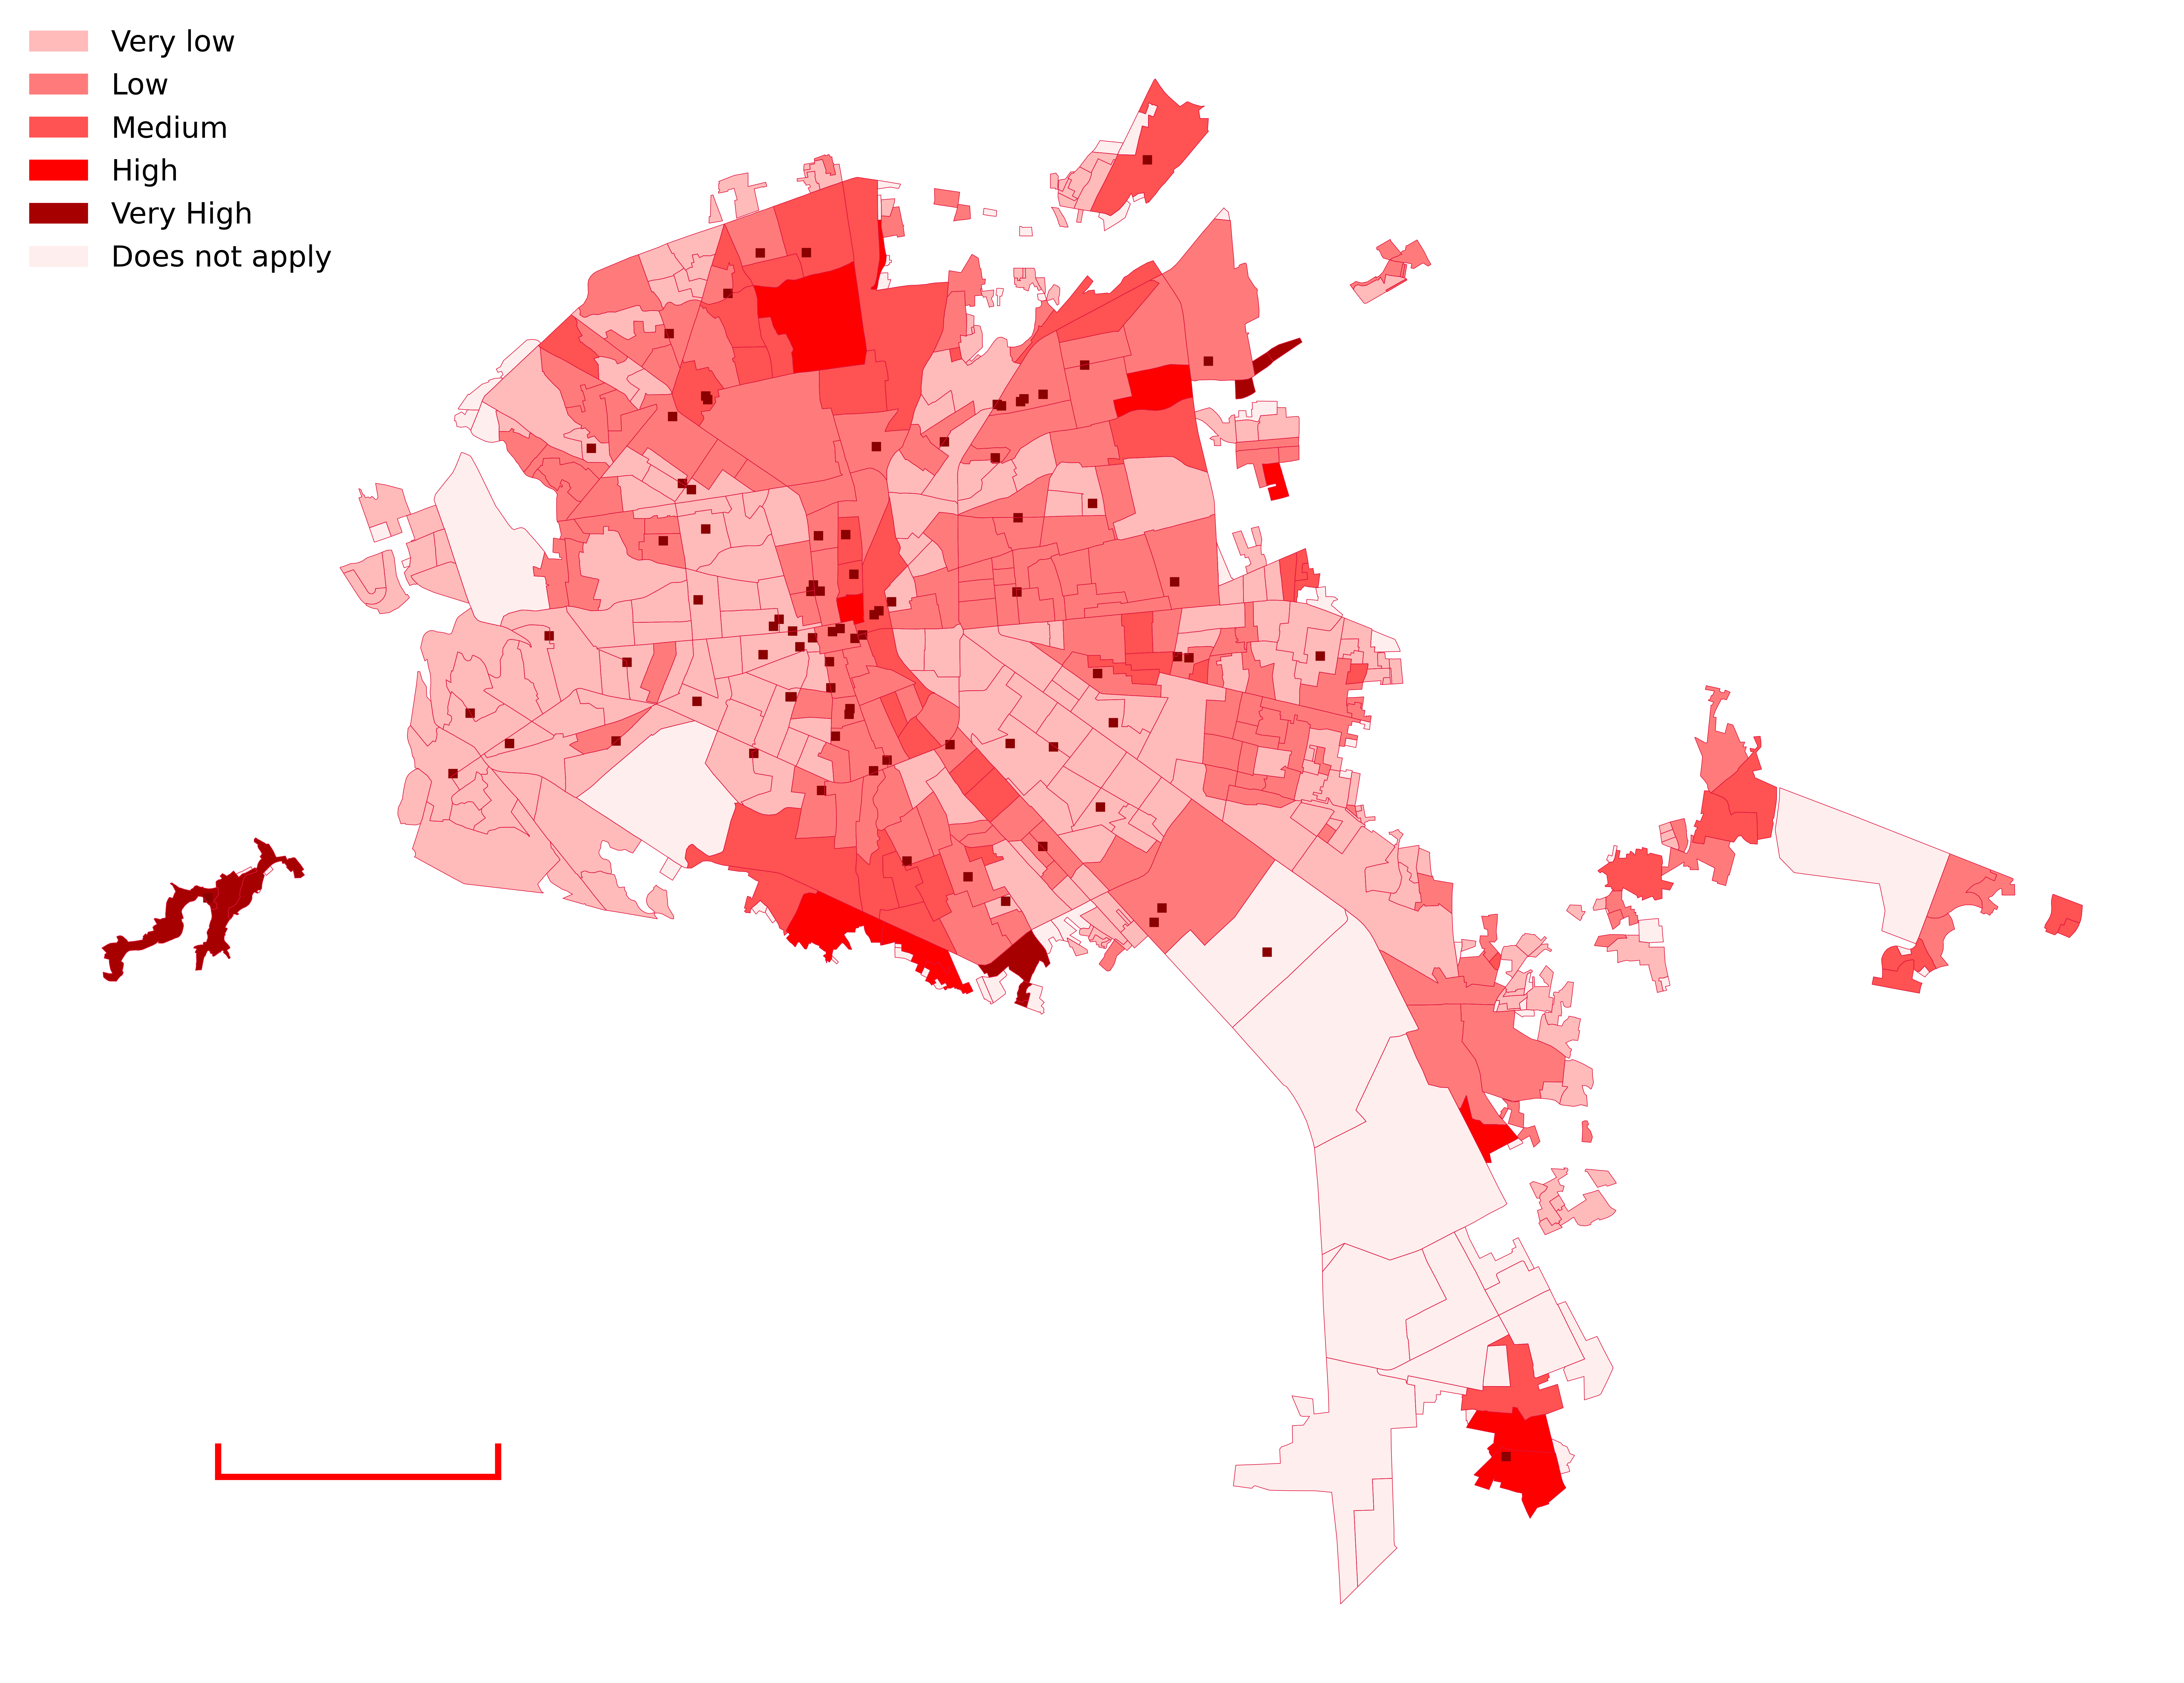

In [16]:
minx, miny, maxx, maxy = gdf_zmslp.geometry.total_bounds
bbox = box(minx,miny,maxx,maxy)
gdf_schools_clipped = gdf_schools.clip(bbox)


colors = {
    'Muy bajo': '#ffbaba',
    'Bajo': '#ff7b7b',
    'Medio': '#ff5252',
    'Alto': '#ff0000',
    'Muy alto': '#a70000',
    'N/A': '#ffeeee',  
}

#ffbaba	(255,186,186)
#ff7b7b	(255,123,123)
#ff5252	(255,82,82)
#ff0000	(255,0,0)
#a70000	(167,0,0)

names = {

    'Muy alto': 'Very High',
    'Alto': 'High',
    'Medio': 'Medium',
    'Bajo': 'Low',
    'Muy bajo': 'Very low',
    'N/A': 'Does not apply'
}


ax =gdf_zmslp.plot(figsize = (100, 100),  color=[colors[d] for d in gdf_zmslp.GM])
gdf_schools_clipped.plot(ax=ax, color = 'darkred', marker='s', markersize=500)
gdf_zmslp.boundary.plot(ax=ax,figsize = (100, 100), edgecolor='crimson')

ax.legend(handles=[mpatches.Patch(color=colors[k], 
                                       label=f'{names[k]}') for k in colors],
               loc='upper left',
               fontsize=75,
               edgecolor='none',
               title='',
               title_fontsize='xx-large',
               bbox_to_anchor=(0.0, 1))


r=6371 # Earth radious
s=5
theta = s/r*180/np.pi
t2 = theta/2
m = 22.025205 
n = -101.075359
plt.plot([n,n+theta ],[m, m],color='red',linewidth=16)
plt.plot([n,n],[m, m+theta/10],color='red',linewidth=16)
plt.plot([n+theta,n+theta ],[m+theta/10,m],color='red',linewidth=16)
ax.set_axis_off()
plt.savefig("../figures/marginalization_in_splma.pdf", format="pdf", bbox_inches="tight",dpi=1000)
plt.show()